<a href="https://colab.research.google.com/github/kunal1709/ksharm11_MachineLearning/blob/master/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kunalsharma1709","key":"1aea0cfb6933c97303ca7cee81141762"}'}

In [ ]:
#shutil.rmtree("./train", ignore_errors=True)

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c dogs-vs-cats

100% 542M/543M [00:02<00:00, 202MB/s]
100% 543M/543M [00:02<00:00, 195MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 92.2MB/s]
 98% 267M/271M [00:01<00:00, 181MB/s]
100% 271M/271M [00:01<00:00, 181MB/s]


In [ ]:
#!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip
!unzip -qq test1.zip

##Question 1
###Consider the Cats & Dogs example. Start initially with a training sample of 1000, a validation sample of 500, and a test sample of500(like in the text). Use any technique to reduce overfitting and improve performance in developing a network that you train from scratch. What performance did you achieve?

In [ ]:
import os, shutil, pathlib
shutil.rmtree("./cats_vs_dogs_small", ignore_errors=True)
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2000)


##Data preprocessing

In [ ]:
# Managing the file direcotry; Splitting the file system into train(1000), test(500) and validation(500) folders
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

for i, element in enumerate(dataset):
    print("Dataset shape",i,":",element.shape)
    if i >= 2:
        break

batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print("Batch shape ",i," :",element.shape)
    if i >= 2:
        break

reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
print("Reshaped datasets")
for i, element in enumerate(reshaped_dataset):
    print("Dataset shape",i,":",element.shape)
    if i >= 2:
        break

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Dataset shape 0 : (16,)
Dataset shape 1 : (16,)
Dataset shape 2 : (16,)
Batch shape  0  : (32, 16)
Batch shape  1  : (32, 16)
Batch shape  2  : (32, 16)
Reshaped datasets
Dataset shape 0 : (4, 4)
Dataset shape 1 : (4, 4)
Dataset shape 2 : (4, 4)


In [ ]:
#Displaying the shapes of the data and labels yielded by the Dataset
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


##Model 

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 128)       73856 

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

##Model Fitting

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 22s 341ms/step - loss: 0.7559 - accuracy: 0.4945 - val_loss: 0.6914 - val_accuracy: 0.5870
Epoch 2/30
63/63 [==============================] - 21s 336ms/step - loss: 0.7098 - accuracy: 0.5480 - val_loss: 0.7221 - val_accuracy: 0.5010
Epoch 3/30
63/63 [==============================] - 21s 330ms/step - loss: 0.6722 - accuracy: 0.5820 - val_loss: 0.6523 - val_accuracy: 0.5960
Epoch 4/30
63/63 [==============================] - 21s 333ms/step - loss: 0.6302 - accuracy: 0.6740 - val_loss: 0.6419 - val_accuracy: 0.6330
Epoch 5/30
63/63 [==============================] - 21s 334ms/step - loss: 0.5938 - accuracy: 0.6820 - val_loss: 0.6071 - val_accuracy: 0.6680
Epoch 6/30
63/63 [==============================] - 21s 337ms/step - loss: 0.5730 - accuracy: 0.7125 - val_loss: 0.6648 - val_accuracy: 0.6610
Epoch 7/30
63/63 [==============================] - 21s 338ms/step - loss: 0.5366 - accuracy: 0.7315 - val_loss: 0.5838 - val_accuracy: 0.6900

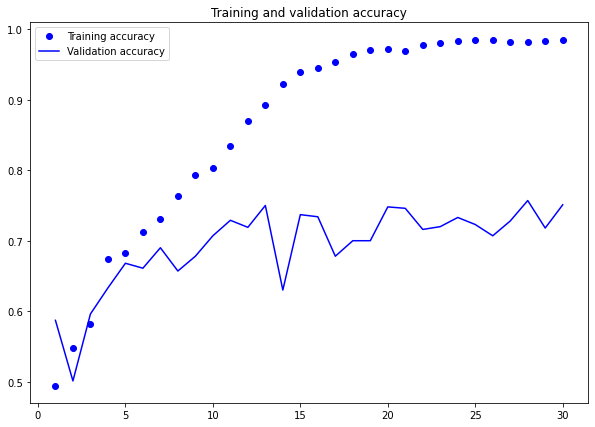

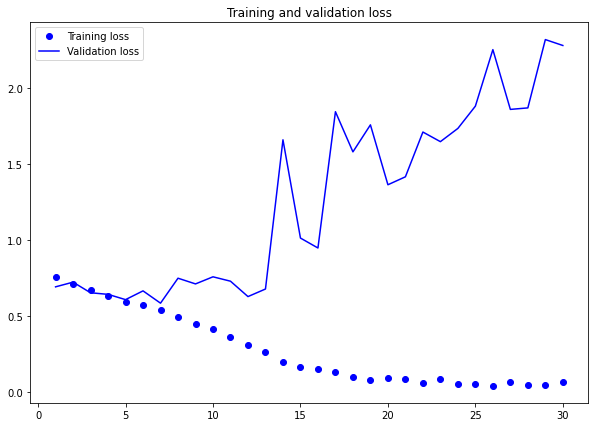

In [ ]:
#Displaying curves of loss and accuracy during training


import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.figure(figsize=(10,7))
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure(figsize=(10,7))
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
#Evaluating the model on the test set
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 55ms/step - loss: 0.6264 - accuracy: 0.6750
Test accuracy: 0.675


In [ ]:
loss1=[]
accurcy=[]
modelname=['model']
loss1.append(np.mean(test_loss))
accurcy.append(np.mean(test_acc))


In [ ]:
len(loss)

30

##Trying for the best Accuracy by adding different % of droput rate and data augmentation to our model 

Define a data augmentation stage to add to an image model

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

Displaying some randomly augmented training images



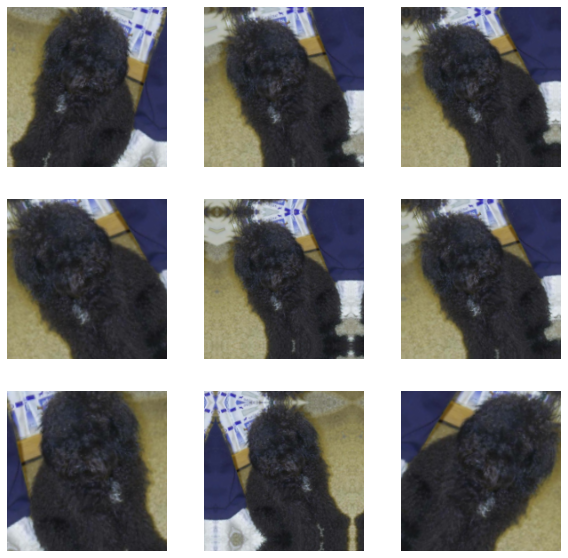

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)    # Layer 1
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.25)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)    # Layer 2
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.20)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)   # Layer 3
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.35)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)   # Layer 4
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.4)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)   # Layer 5

x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_1 = keras.Model(inputs=inputs, outputs=outputs)
model_1.summary()

model_1.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 89, 89, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 43, 43, 64)        0   

##Model_1 Fitting to data and increasing epochs

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_model_1.keras",
        save_best_only=True,
        monitor="val_loss")
]
history1 = model_1.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 24s 362ms/step - loss: 0.7592 - accuracy: 0.5015 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 23s 362ms/step - loss: 0.6994 - accuracy: 0.5355 - val_loss: 0.6895 - val_accuracy: 0.5680
Epoch 3/30
63/63 [==============================] - 23s 366ms/step - loss: 0.6974 - accuracy: 0.5355 - val_loss: 0.6673 - val_accuracy: 0.6170
Epoch 4/30
63/63 [==============================] - 23s 368ms/step - loss: 0.6590 - accuracy: 0.6260 - val_loss: 0.7735 - val_accuracy: 0.5570
Epoch 5/30
63/63 [==============================] - 23s 362ms/step - loss: 0.6184 - accuracy: 0.6510 - val_loss: 0.6210 - val_accuracy: 0.6600
Epoch 6/30
63/63 [==============================] - 23s 362ms/step - loss: 0.6100 - accuracy: 0.6735 - val_loss: 0.6262 - val_accuracy: 0.6540
Epoch 7/30
63/63 [==============================] - 23s 368ms/step - loss: 0.5969 - accuracy: 0.6725 - val_loss: 0.6754 - val_accuracy: 0.6240

In [ ]:
#Displaying curves of loss and accuracy during training

import matplotlib.pyplot as plt
accuracy = history1.history["accuracy"]
val_accuracy = history1.history["val_accuracy"]
loss = history1.history["loss"]
val_loss = history1.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.figure(figsize=(10,7))
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure(figsize=(10,7))
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
#Evaluating the model on the test set
test_model = keras.models.load_model("convnet_from_scratch_model_1.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)

print(f"Test accuracy: {test_acc:.3f}")

In [ ]:
modelname=['model','model_1']
loss1.append(np.mean(test_loss))
accurcy.append(np.mean(test_acc))


In [28]:
loss1

[0.6263572573661804, 0.594975471496582]

We can see the accuracy of both the model and model_1 are almost

##Question 2
###Increase your training sample size. You may pick any amount. Keep the validation and test samples the same as above. Optimize your network (again training from scratch). What performance did you achieve?

In [ ]:
import os, shutil, pathlib
shutil.rmtree("./cats_vs_dogs_small", ignore_errors=True)
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=2000)
make_subset("validation", start_index=2000, end_index=2500)
make_subset("test", start_index=2500, end_index=3000)

###Data Preprocessing

In [ ]:
# Managing the file direcotry; Splitting the file system into train(1000), test(500) and validation(500) folders
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

for i, element in enumerate(dataset):
    print("Dataset shape",i,":",element.shape)
    if i >= 2:
        break

batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print("Batch shape ",i," :",element.shape)
    if i >= 2:
        break

reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
print("Reshaped datasets")
for i, element in enumerate(reshaped_dataset):
    print("Dataset shape",i,":",element.shape)
    if i >= 2:
        break

####Displaying the shapes of the data and labels yielded by the Dataset

In [ ]:

for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

###Fitting model to new dataset

In [29]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_3.keras",
        save_best_only=True,
        monitor="val_loss")
]
history3 = model_1.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
125/125 [==============================] - 42s 335ms/step - loss: 0.1654 - accuracy: 0.9345 - val_loss: 0.7007 - val_accuracy: 0.7630
Epoch 2/30
125/125 [==============================] - 42s 334ms/step - loss: 0.1514 - accuracy: 0.9380 - val_loss: 0.7538 - val_accuracy: 0.7720
Epoch 3/30
125/125 [==============================] - 42s 337ms/step - loss: 0.1351 - accuracy: 0.9488 - val_loss: 0.7575 - val_accuracy: 0.7820
Epoch 4/30
125/125 [==============================] - 42s 337ms/step - loss: 0.1355 - accuracy: 0.9513 - val_loss: 0.9232 - val_accuracy: 0.7580
Epoch 5/30
125/125 [==============================] - 42s 334ms/step - loss: 0.1302 - accuracy: 0.9538 - val_loss: 0.9140 - val_accuracy: 0.7560
Epoch 6/30
125/125 [==============================] - 42s 339ms/step - loss: 0.1300 - accuracy: 0.9540 - val_loss: 1.0638 - val_accuracy: 0.7690
Epoch 7/30
125/125 [==============================] - 42s 334ms/step - loss: 0.1303 - accuracy: 0.9578 - val_loss: 1.0779 - val_ac

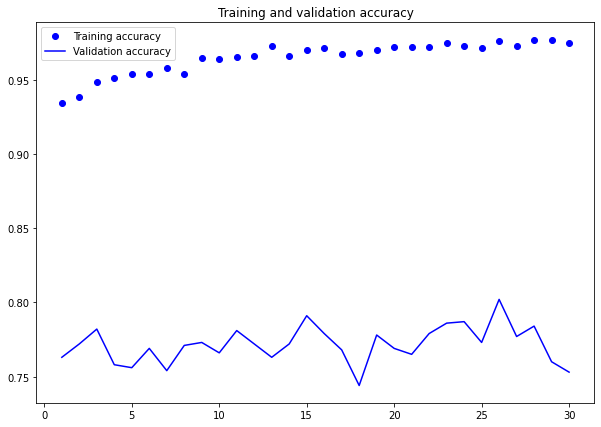

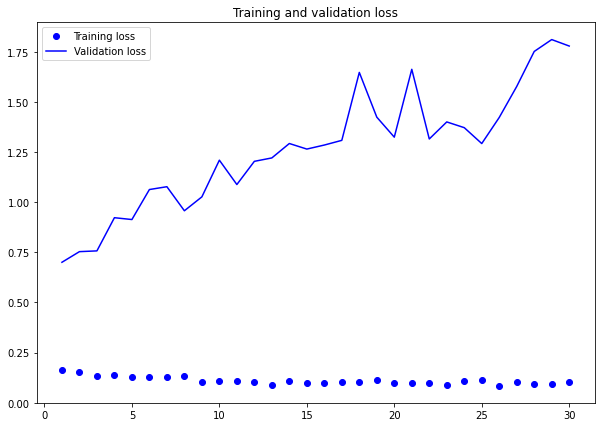

In [30]:
#Displaying curves of loss and accuracy during training


import matplotlib.pyplot as plt
accuracy = history3.history["accuracy"]
val_accuracy = history3.history["val_accuracy"]
loss = history3.history["loss"]
val_loss = history3.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.figure(figsize=(10,7))
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure(figsize=(10,7))
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [31]:
#Evaluating the model on the test set
test_model = keras.models.load_model("convnet_from_scratch_3.keras")
test_loss, test_acc = model_1.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 56ms/step - loss: 2.1392 - accuracy: 0.7340
Test accuracy: 0.734


In [32]:
loss1.append(np.mean(test_loss))
accurcy.append(np.mean(test_acc))

In [33]:
loss1

[0.6263572573661804, 0.594975471496582, 2.1392126083374023]

We can see the accuracy of new dataset is better than the previous one. We can see the increase in accuracy after the change in the dataset

##Question 3
###Now change your training sample so that you achieve better performance than those from Steps 1 and 2. This sample size may be larger, or smaller than those in the previous steps. The objective is to find the ideal training sample size to get best prediction results.

In [34]:
#Here I will be taking the mean amount of training set as of question 1 and 2
import os, shutil, pathlib
shutil.rmtree("./cats_vs_dogs_small", ignore_errors=True)
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1500)
make_subset("validation", start_index=1500, end_index=1750)
make_subset("test", start_index=1750, end_index=2000)

###Data Preprocessing

In [35]:

from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

for i, element in enumerate(dataset):
    print("Dataset shape",i,":",element.shape)
    if i >= 2:
        break

batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print("Batch shape ",i," :",element.shape)
    if i >= 2:
        break

reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
print("Reshaped datasets")
for i, element in enumerate(reshaped_dataset):
    print("Dataset shape",i,":",element.shape)
    if i >= 2:
        break

Found 3000 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Dataset shape 0 : (16,)
Dataset shape 1 : (16,)
Dataset shape 2 : (16,)
Batch shape  0  : (32, 16)
Batch shape  1  : (32, 16)
Batch shape  2  : (32, 16)
Reshaped datasets
Dataset shape 0 : (4, 4)
Dataset shape 1 : (4, 4)
Dataset shape 2 : (4, 4)


####Displaying the shapes of the data and labels yielded by the Dataset

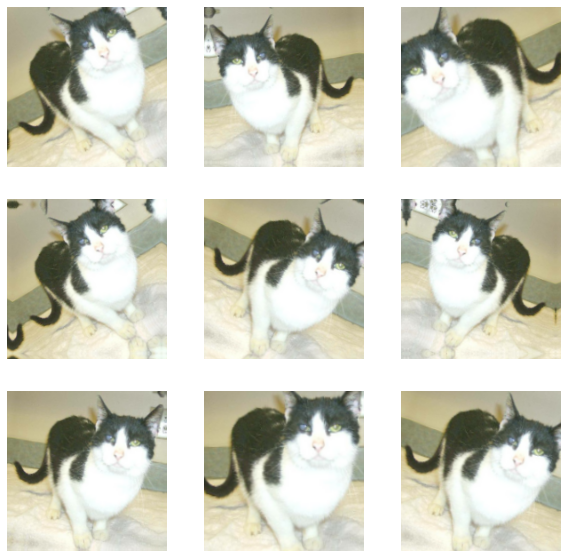

In [36]:

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

###Fitting Model to new Datset 

In [37]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_4.keras",
        save_best_only=True,
        monitor="val_loss")
]
history4 = model_1.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
94/94 [==============================] - 31s 330ms/step - loss: 0.0949 - accuracy: 0.9753 - val_loss: 0.0355 - val_accuracy: 0.9900
Epoch 2/30
94/94 [==============================] - 31s 330ms/step - loss: 0.1123 - accuracy: 0.9710 - val_loss: 0.0193 - val_accuracy: 0.9920
Epoch 3/30
94/94 [==============================] - 31s 328ms/step - loss: 0.0790 - accuracy: 0.9790 - val_loss: 0.0052 - val_accuracy: 0.9980
Epoch 4/30
94/94 [==============================] - 31s 330ms/step - loss: 0.0940 - accuracy: 0.9790 - val_loss: 0.0176 - val_accuracy: 0.9920
Epoch 5/30
94/94 [==============================] - 31s 330ms/step - loss: 0.0665 - accuracy: 0.9817 - val_loss: 0.0364 - val_accuracy: 0.9860
Epoch 6/30
94/94 [==============================] - 31s 327ms/step - loss: 0.0836 - accuracy: 0.9797 - val_loss: 0.0317 - val_accuracy: 0.9880
Epoch 7/30
94/94 [==============================] - 31s 331ms/step - loss: 0.0980 - accuracy: 0.9787 - val_loss: 0.1250 - val_accuracy: 0.9660

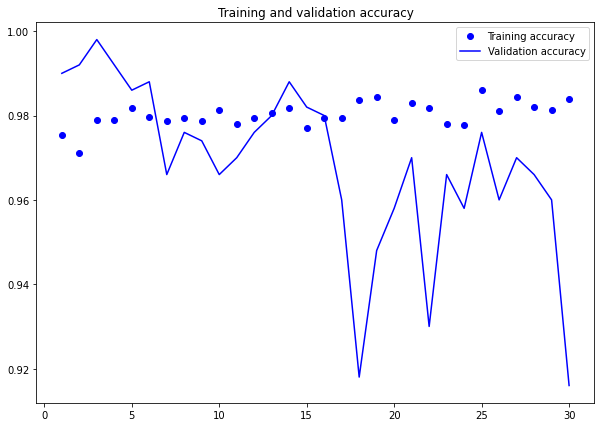

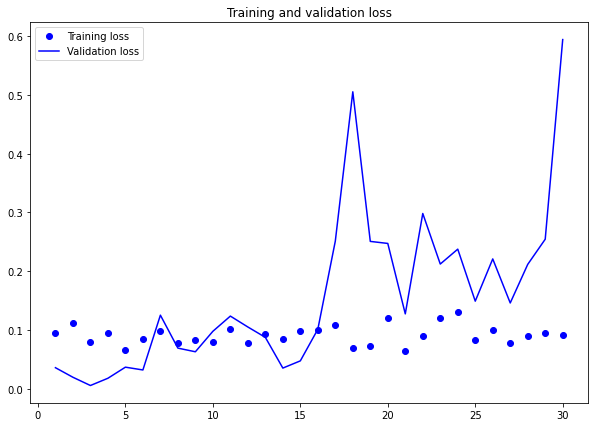

In [38]:
#Displaying curves of loss and accuracy during training


import matplotlib.pyplot as plt
accuracy = history4.history["accuracy"]
val_accuracy = history4.history["val_accuracy"]
loss = history4.history["loss"]
val_loss = history4.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.figure(figsize=(10,7))
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure(figsize=(10,7))
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [39]:
#Evaluating the model on the test set
test_model = keras.models.load_model("convnet_from_scratch_4.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

16/16 [==============================] - 1s 55ms/step - loss: 0.0110 - accuracy: 0.9960
Test accuracy: 0.996


In [40]:
loss1.append(np.mean(test_loss))
accurcy.append(np.mean(test_acc))

##Question 4
###Repeat Steps 1-3, but now using a pretrained network. The sample sizes you use in Steps 2 and 3 for the pretrained network may be the same or different from those using the network where you trained from scratch. Again, useany and alloptimization techniques to get best performance.

In [42]:
import os, shutil, pathlib
shutil.rmtree("./cats_vs_dogs_small", ignore_errors=True)
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2000)

In [43]:
# Managing the file direcotry; Splitting the file system into train(1000), test(500) and validation(500) folders
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [44]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58900480/58889256 [==============================] - 0s 0us/step


In [45]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

In [46]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history_3 = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 1s 11ms/step - loss: 14.0920 - accuracy: 0.9275 - val_loss: 3.7301 - val_accuracy: 0.9670
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 3.5728 - accuracy: 0.9755 - val_loss: 3.6774 - val_accuracy: 0.9720
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 1.8532 - accuracy: 0.9825 - val_loss: 4.5095 - val_accuracy: 0.9750
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 1.6475 - accuracy: 0.9860 - val_loss: 4.1840 - val_accuracy: 0.9770
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 0.5381 - accuracy: 0.9915 - val_loss: 8.4318 - val_accuracy: 0.9640
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 0.6238 - accuracy: 0.9950 - val_loss: 7.0067 - val_accuracy: 0.9710
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 0.6630 - accuracy: 0.9940 - val_loss: 4.1545 - val_accuracy: 0.9750
Epoch 8/20
63/63 [

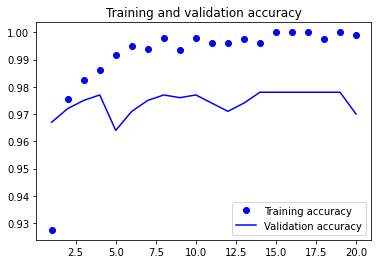

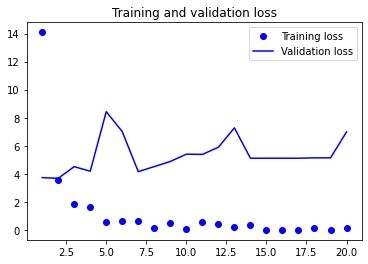

In [47]:
import matplotlib.pyplot as plt
acc = history_3.history["accuracy"]
val_acc = history_3.history["val_accuracy"]
loss = history_3.history["loss"]
val_loss = history_3.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

In [53]:
loss1.append(np.mean(test_loss))
accurcy.append(np.mean(test_acc))

As of data used in second answer

In [54]:
import os, shutil, pathlib
shutil.rmtree("./cats_vs_dogs_small", ignore_errors=True)
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=2000)
make_subset("validation", start_index=2000, end_index=2500)
make_subset("test", start_index=2500, end_index=3000)

# Managing the file direcotry; Splitting the file system into train(1000), test(500) and validation(500) folders
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 4000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [55]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

In [56]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))
conv_base.trainable = False
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26
This is the number of trainable weights before freezing the conv base: 0


In [57]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [58]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history_final_3 = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
125/125 [==============================] - 99s 782ms/step - loss: 12.8115 - accuracy: 0.9165 - val_loss: 5.5534 - val_accuracy: 0.9670
Epoch 2/30
125/125 [==============================] - 98s 783ms/step - loss: 6.4605 - accuracy: 0.9523 - val_loss: 5.8288 - val_accuracy: 0.9630
Epoch 3/30
125/125 [==============================] - 97s 780ms/step - loss: 4.9858 - accuracy: 0.9605 - val_loss: 3.6780 - val_accuracy: 0.9800
Epoch 4/30
125/125 [==============================] - 97s 779ms/step - loss: 4.3455 - accuracy: 0.9620 - val_loss: 4.3988 - val_accuracy: 0.9740
Epoch 5/30
125/125 [==============================] - 97s 780ms/step - loss: 3.1775 - accuracy: 0.9682 - val_loss: 5.3202 - val_accuracy: 0.9670
Epoch 6/30
125/125 [==============================] - 97s 780ms/step - loss: 2.7787 - accuracy: 0.9703 - val_loss: 2.8988 - val_accuracy: 0.9720
Epoch 7/30
125/125 [==============================] - 97s 778ms/step - loss: 2.9248 - accuracy: 0.9665 - val_loss: 4.6062 - val_a

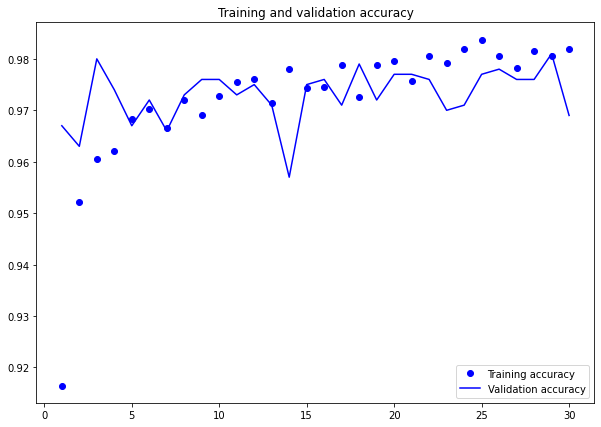

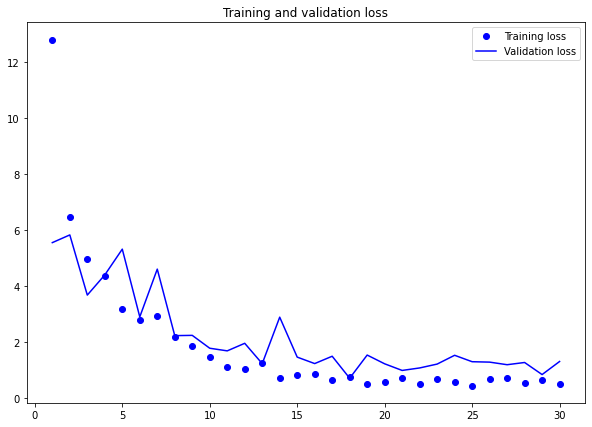

In [59]:
import matplotlib.pyplot as plt
acc = history_final_3.history["accuracy"]
val_acc = history_final_3.history["val_accuracy"]
loss = history_final_3.history["loss"]
val_loss = history_final_3.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(10,7))
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure(figsize=(10,7))
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [60]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 19s 600ms/step - loss: 1.2212 - accuracy: 0.9690
Test accuracy: 0.969


In [70]:
loss1
accurcy

[0.675000011920929,
 0.6819999814033508,
 0.734000027179718,
 0.9959999918937683,
 0.9959999918937683,
 0.968999981880188]

In [62]:
loss1.append(np.mean(test_loss))
accurcy.append(np.mean(test_acc))

Now as of the best dataset that used for model from scratch in answer 3

In [64]:
#Here I will be taking the mean amount of training set as of question 1 and 2
import os, shutil, pathlib
shutil.rmtree("./cats_vs_dogs_small", ignore_errors=True)
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1500)
make_subset("validation", start_index=1500, end_index=1750)
make_subset("test", start_index=1750, end_index=2000)

In [65]:

from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)


Found 3000 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


In [66]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [67]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])   

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history_final_RM_3 = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
94/94 [==============================] - 85s 884ms/step - loss: 0.6092 - accuracy: 0.9820 - val_loss: 0.1189 - val_accuracy: 0.9920
Epoch 2/30
94/94 [==============================] - 83s 882ms/step - loss: 0.3615 - accuracy: 0.9860 - val_loss: 0.1146 - val_accuracy: 0.9980
Epoch 3/30
94/94 [==============================] - 83s 880ms/step - loss: 0.2197 - accuracy: 0.9883 - val_loss: 0.0631 - val_accuracy: 0.9980
Epoch 4/30
94/94 [==============================] - 83s 882ms/step - loss: 0.3260 - accuracy: 0.9867 - val_loss: 0.2452 - val_accuracy: 0.9900
Epoch 5/30
94/94 [==============================] - 83s 879ms/step - loss: 0.2588 - accuracy: 0.9880 - val_loss: 0.0615 - val_accuracy: 0.9960
Epoch 6/30
94/94 [==============================] - 83s 878ms/step - loss: 0.1800 - accuracy: 0.9907 - val_loss: 0.0717 - val_accuracy: 0.9980
Epoch 7/30
94/94 [==============================] - 82s 878ms/step - loss: 0.1427 - accuracy: 0.9907 - val_loss: 0.1933 - val_accuracy: 0.9940

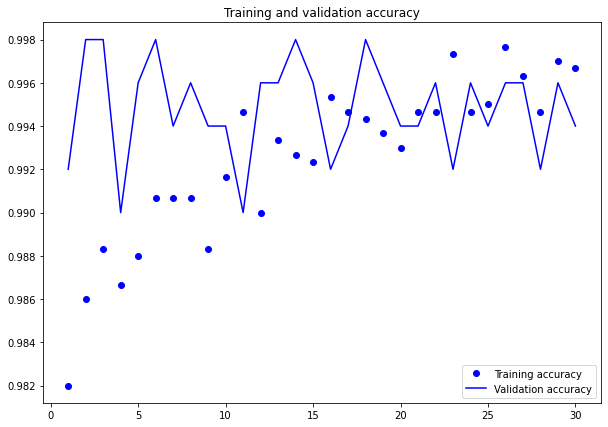

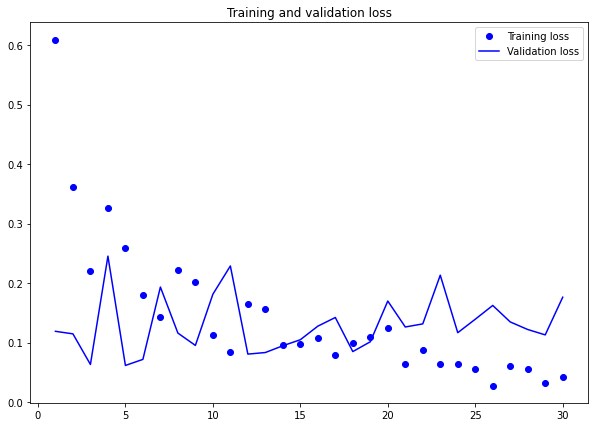

In [68]:
import matplotlib.pyplot as plt
acc = history_final_RM_3.history["accuracy"]
val_acc = history_final_RM_3.history["val_accuracy"]
loss = history_final_RM_3.history["loss"]
val_loss = history_final_RM_3.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(10,7))
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure(figsize=(10,7))
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [69]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

16/16 [==============================] - 9s 574ms/step - loss: 0.0353 - accuracy: 0.9940
Test accuracy: 0.994


In [71]:
loss1.append(np.mean(test_loss))
accurcy.append(np.mean(test_acc))

In [77]:
print(loss1,'\n',accurcy)

[0.6263572573661804, 0.594975471496582, 2.1392126083374023, 0.010953199118375778, 0.010953199118375778, 1.221186637878418, 0.035336028784513474] 
 [0.675000011920929, 0.6819999814033508, 0.734000027179718, 0.9959999918937683, 0.9959999918937683, 0.968999981880188, 0.9940000176429749]


In [106]:
labels=['convnet_from_scratch','convnet_from_scratch_model_1','convnet_from_scratch_3','convnet_from_scratch_4','pretrained_feature_extraction','pretrained_feature_extraction_with_data_augmentation','pretrained_fine_tuning']

In [75]:
All_Loss= np.array([0.6263572573661804,
 0.594975471496582,
 2.1392126083374023,
 0.010953199118375778,
 0.010953199118375778,
 1.221186637878418,
 0.035336028784513474])*100
All_Loss
All_Accuracy= np.array([0.675000011920929,
 0.6819999814033508,
 0.734000027179718,
 0.9959999918937683,
 0.9959999918937683,
 0.968999981880188,
 0.9940000176429749])*100
All_Accuracy
plt.clf()

<Figure size 432x288 with 0 Axes>

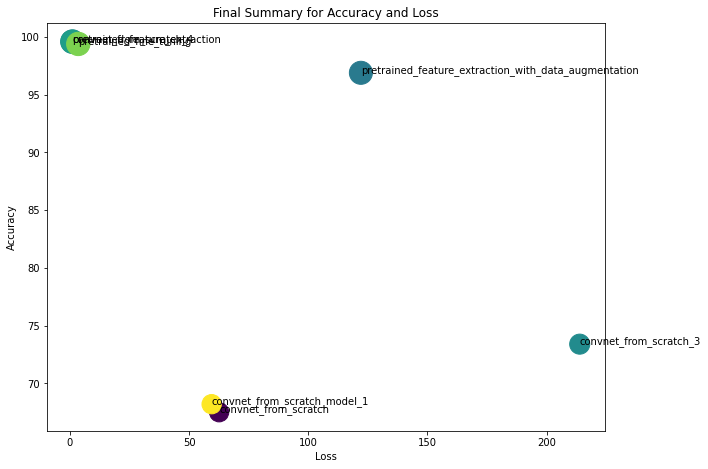

In [131]:
fig, ax = plt.subplots(figsize=(10,7.5))
ax.scatter(All_Loss,All_Accuracy,c = np.random.rand(len(All_Accuracy)),s = np.sqrt(30 * All_Accuracy**2))
for i, txt in enumerate(labels):
    ax.annotate(txt, (All_Loss[i],All_Accuracy[i] ))
plt.title("Final Summary for Accuracy and Loss")
plt.ylabel("Accuracy")
plt.xlabel("Loss")

plt.show()

#Summary

As we could see in the Above plot, we could conclude that:


Train Set:  Because we used a small sample set for training, the model was unable to extract the characteristics of the data, and so the performance was poor.

Training Techniques – Similarly, the performance of the pretrained layer appears to be slightly better than that of the model created from scratch. However, the loss for the Pretrained network is significantly little higher.


Looking at the Loss and Accuracy, we can conclude that the best model created for the cat-vs-dogs dataset is a pretrained model on VGG16 with a training sample of 1500, where we acquired an accuracy of ~99 percent and a loss of roughly ~0.5.

However, this may not be true for all types of image processing, and hypertuning is always important. We can always develop a better model by using hypertuning techniques and implementing procedures under the correct conditions.